# Benchmark MIOST sea surface height maps 3 nadirs + 1 SWOT

<div style="text-align: right"><i> 2024-05-20 MIOST_3NADIRS_1SWOT_SSH_BENCHMARK_DEMO </i></div>

***
**Authors:**  CLS  <br>
**Copyright:** 2024 CLS <br>
**License:** MIT

<div class="alert alert-block alert-success">
<h1><center>Benchmark of MIOST sea surface height maps contructed from 3 nadirs + 1 SWOT wide-swath</center></h1>
<h5> The notebook aims to evaluate the sea surface height maps produced by the MIOST system. </h5>
        <h5> We provide below a demonstration of the validation of these maps against the independent SSH data from the Saral/AltiKa altimeter distributed by CMEMS </h5>
</div>

In [2]:
from glob import glob
import numpy as np
import os

In [3]:
import sys
sys.path.append('..')
from src.mod_plot import *
from src.mod_stat import *
from src.mod_spectral import *

In [4]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

<div class="alert alert-info" role="alert">

<h2>0. Parameters</h2>

</div>

In [5]:
time_min = '2023-08-01'                                                           # time min for analysis
time_max = '2024-05-01'                                                           # time max for analysis
output_dir = './results'                                                          # output directory path
os.system(f'mkdir -p {output_dir}')
stat_output_filename = f'{output_dir}/stat_mapping_miost_s3a_s3b_s6a-hr_swot.nc'  # output statistical analysis filename
lambda_min = 65.                                                                  # minimun spatial scale in kilometer to consider on the filtered signal
lambda_max = 200.                                                                 # maximum spatial scale in kilometer to consider on the filtered signal
psd_output_filename = f'{output_dir}/psd_mapping_miost_s3a_s3b_s6a-hr_swot.nc'    # output spectral analysis filename
segment_lenght = 1000.                                                            # spectral parameer: along-track segment lenght in kilometer to consider in the spectral analysis

<div class="alert alert-info" role="alert">

<h2>1. Input files</h2>

</div>

## Sea Surface Height from Saral/AltiKa

In [6]:
%%time
list_of_file = sorted(glob('../data/independent_alongtrack/al/*/*.nc'))
ds_alg = xr.open_mfdataset(list_of_file, combine='nested', concat_dim='time')
ds_alg = ds_alg.where((ds_alg.time >= np.datetime64(time_min)) & (ds_alg.time <=  np.datetime64(time_max)), drop=True)
ds_alg = ds_alg.sortby('time')
ds_alg

CPU times: user 41 s, sys: 12.9 s, total: 53.8 s
Wall time: 55.3 s


<xarray.Dataset>
Dimensions:         (time: 10792492)
Coordinates:
  * time            (time) datetime64[ns] 2023-08-01T00:11:42.253617152 ... 2...
    longitude       (time) float64 dask.array<chunksize=(44060,), meta=np.ndarray>
    latitude        (time) float64 dask.array<chunksize=(44060,), meta=np.ndarray>
Data variables:
    cycle           (time) float64 dask.array<chunksize=(44060,), meta=np.ndarray>
    track           (time) float64 dask.array<chunksize=(44060,), meta=np.ndarray>
    sla_filtered    (time) float32 dask.array<chunksize=(44060,), meta=np.ndarray>
    sla_unfiltered  (time) float32 dask.array<chunksize=(44060,), meta=np.ndarray>
    flag            (time) float32 dask.array<chunksize=(44060,), meta=np.ndarray>
    dac             (time) float32 dask.array<chunksize=(44060,), meta=np.ndarray>
    ocean_tide      (time) float32 dask.array<chunksize=(44060,), meta=np.ndarray>
    internal_tide   (time) float32 dask.array<chunksize=(44060,), meta=np.ndarray>
    lwe             (time) float32 dask.array<chunksize=(44060,), meta=np.ndarray>
    mdt             (time) float32 dask.array<chunksize=(44060,), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea Surface Height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Near-Real-Time Level-3 sea ...
    time_coverage_duration:          P23H56M4.225698S
    time_coverage_end:               2023-06-10T23:59:37Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2023-06-10T00:03:33Z
    title:                           NRT Altika Drifting Phase Global Ocean A...

## Sea Surface Height maps to evaluate

In [7]:
%%time
list_of_maps = sorted(glob('../data/mapping_miost_s3a_s3b_s6a-hr_swot/*.nc'))

ds_maps = xr.open_mfdataset(list_of_maps, combine='nested', concat_dim='time')
ds_maps = ds_maps.sel(time=slice(time_min, time_max))
ds_maps

CPU times: user 23.1 s, sys: 6.93 s, total: 30.1 s
Wall time: 33 s


<xarray.Dataset>
Dimensions:             (longitude: 3600, latitude: 1701, time: 275, bounds: 2)
Coordinates:
  * longitude           (longitude) float64 0.0 0.1 0.2 ... 359.7 359.8 359.9
  * latitude            (latitude) float32 -80.0 -79.9 -79.8 ... 89.8 89.9 90.0
  * time                (time) datetime64[ns] 2023-08-01 ... 2024-05-01
    longitude_bounds    (longitude, bounds) float64 dask.array<chunksize=(3600, 2), meta=np.ndarray>
    latitude_bounds     (latitude, bounds) float64 dask.array<chunksize=(1701, 2), meta=np.ndarray>
Dimensions without coordinates: bounds
Data variables:
    sla                 (time, latitude, longitude) float64 dask.array<chunksize=(1, 1701, 3600), meta=np.ndarray>
    ugosa               (time, latitude, longitude) float64 dask.array<chunksize=(1, 1701, 3600), meta=np.ndarray>
    vgosa               (time, latitude, longitude) float64 dask.array<chunksize=(1, 1701, 3600), meta=np.ndarray>
    relative_vorticity  (time, latitude, longitude) float64 dask.array<chunksize=(1, 1701, 3600), meta=np.ndarray>
    adt                 (time, latitude, longitude) float64 dask.array<chunksize=(1, 1701, 3600), meta=np.ndarray>
    ugos                (time, latitude, longitude) float64 dask.array<chunksize=(1, 1701, 3600), meta=np.ndarray>
    vgos                (time, latitude, longitude) float64 dask.array<chunksize=(1, 1701, 3600), meta=np.ndarray>
Attributes: (12/45)
    description:                      Miost analysis 
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         
    ...                              ...
    summary:                         Experimental SSALTO/DUACS Delayed-Time L...
    time_coverage_duration:          P1D
    time_coverage_resolution:        P1D
    title:                           DT merged all satellites Global Ocean Gr...
    time_coverage_start:             2023-07-27T12:00:00Z
    time_coverage_end:               2023-07-27T12:00:00Z

<div class="alert alert-info" role="alert">
<h2>2. Statistical & Spectral Analysis </h2>
</div>

## 2.1 Interpolate sea surface height maps onto along-track positions

In [8]:
ds_interp = run_interpolation(ds_maps, ds_alg)
ds_interp = ds_interp.dropna('time')
ds_interp

2024-05-31 07:03:58 INFO     fetch data from 2023-08-01 00:00:00 to 2023-09-01 00:00:00
2024-05-31 07:04:03 INFO     fetch data from 2023-08-31 00:00:00 to 2023-10-01 00:00:00
2024-05-31 07:04:08 INFO     fetch data from 2023-09-30 00:00:00 to 2023-11-01 00:00:00
2024-05-31 07:04:12 INFO     fetch data from 2023-10-31 00:00:00 to 2023-12-01 00:00:00
2024-05-31 07:04:17 INFO     fetch data from 2023-11-30 00:00:00 to 2024-01-01 00:00:00
2024-05-31 07:04:21 INFO     fetch data from 2023-12-31 00:00:00 to 2024-02-01 00:00:00
2024-05-31 07:04:26 INFO     fetch data from 2024-01-31 00:00:00 to 2024-03-01 00:00:00
2024-05-31 07:04:30 INFO     fetch data from 2024-02-29 00:00:00 to 2024-04-01 00:00:00
2024-05-31 07:04:34 INFO     fetch data from 2024-03-31 00:00:00 to 2024-05-01 00:00:00


<xarray.Dataset>
Dimensions:            (time: 10749260)
Coordinates:
  * time               (time) datetime64[ns] 2023-08-01T00:11:42.253617152 .....
Data variables: (12/13)
    cycle              (time) float64 173.0 173.0 173.0 ... 181.0 181.0 181.0
    track              (time) float64 805.0 805.0 805.0 ... 633.0 633.0 633.0
    sla_filtered       (time) float32 -0.045 -0.027 -0.016 ... 0.193 0.188 0.186
    sla_unfiltered     (time) float32 -0.026 -0.066 0.031 ... 0.2 0.179 0.177
    flag               (time) float32 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    dac                (time) float32 0.184 0.184 0.184 ... 0.048 0.048 0.048
    ...                 ...
    internal_tide      (time) float32 0.0 0.0 0.0 0.0 ... -0.001 -0.001 -0.001
    lwe                (time) float32 0.019 0.018 0.018 ... -0.005 -0.005 -0.005
    mdt                (time) float32 -1.247 -1.228 -1.223 ... 0.852 0.852 0.852
    longitude          (time) float64 100.6 100.3 100.3 ... 88.42 88.4 88.39
    latitude           (time) float64 -60.31 -60.01 -59.95 ... -0.02314 0.03816
    msla_interpolated  (time) float64 0.00539 -0.027 -0.0281 ... 0.1837 0.1848

## 2.2 Compute grid boxes statistics & statistics by regime (coastal, offshore low variability, offshore high variability)

Once the maps have been interpolated to the position of the along-track, it is possible to calculate different statistics on the time series SLA_alongtrack and SLA_maps. 

We propose below the following statistics: error variance maps (static by 1°x1° box), explained variance maps, temporal evolution of global error variance and explained variance. 

These statistics are also applied to the filtered signals focusing on the 65-200km scale range. A bandpass filter is applied before calculating the scores.  

In [9]:
compute_stat_scores(ds_interp, lambda_min, lambda_max, stat_output_filename)

2024-05-31 07:04:40 INFO     Compute mapping error all scales
2024-05-31 07:04:40 INFO     Compute mapping error for scales between 65.0 and 200.0 km
2024-05-31 07:05:09 INFO     Compute binning statistics
2024-05-31 07:05:38 INFO     Compute statistics by oceanic regime
2024-05-31 07:06:03 INFO     Stat file saved as: ./results/stat_mapping_miost_s3a_s3b_s6a-hr_swot.nc


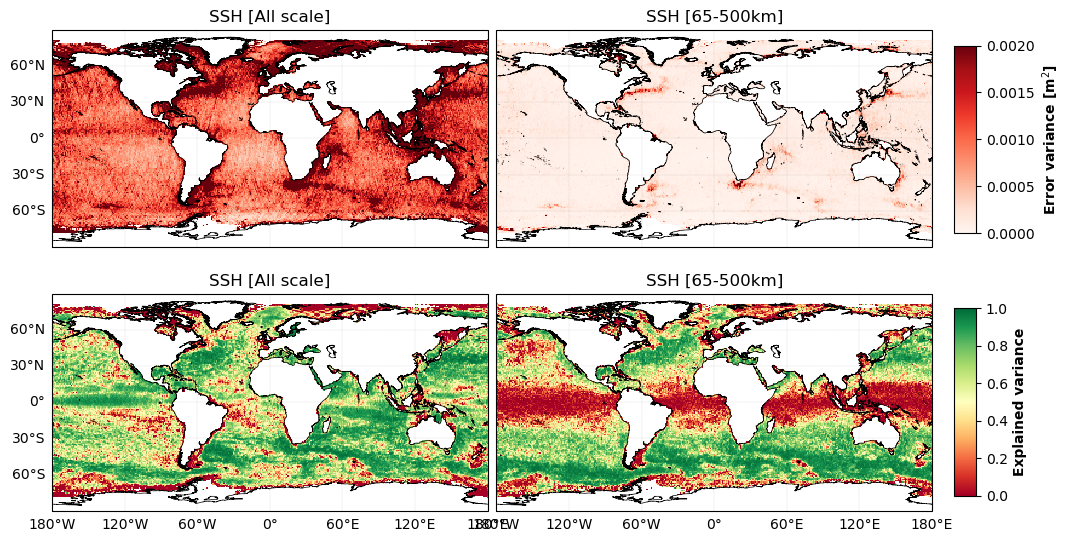

In [10]:
# Plot gridded stats
# Hvplot
# plot_stat_score_map(stat_output_filename)
# Matplotlib
plot_stat_score_map_png(stat_output_filename)

In [11]:
plot_stat_score_timeseries(stat_output_filename)

:Layout
   .Overlay.I  :Overlay
      .Curve.All_scale :Curve   [time]   (timeserie_variance_mapping_err)
      .Curve.Filtered  :Curve   [time]   (timeserie_variance_mapping_err)
   .Overlay.II :Overlay
      .Curve.All_scale :Curve   [time]   (explained_variance_score)
      .Curve.Filtered  :Curve   [time]   (explained_variance_score)

In [12]:
plot_stat_by_regimes(stat_output_filename)

,mapping_err_var [m²],sla_unfiltered_var [m²],mapping_err_filtered_var [m²],sla_filtered_var [m²],var_score_allscale,var_score_filtered
coastal,0.003120,0.010191,0.000236,0.000492,0.693855,0.519650
offshore_highvar,0.002516,0.056571,0.000360,0.004009,0.955518,0.910221
offshore_lowvar,0.001164,0.007027,0.000101,0.000466,0.834338,0.783551
equatorial_band,0.001580,0.008309,0.000150,0.000162,0.809822,0.071175
arctic,0.003280,0.008628,0.000175,0.000308,0.619800,0.431201
antarctic,0.005393,0.003041,0.000231,0.000273,-0.773338,0.153112


## 2.3 Compute Spectral scores

In [13]:
compute_psd_scores_v2(ds_interp, psd_output_filename, lenght_scale=segment_lenght)

2024-05-31 07:06:10 INFO     Segment computation...
2024-05-31 07:06:16 INFO     Spectral analysis...
2024-05-31 07:09:46 INFO     Saving ouput...
2024-05-31 07:09:52 INFO     PSD file saved as: ./results/psd_mapping_miost_s3a_s3b_s6a-hr_swot.nc


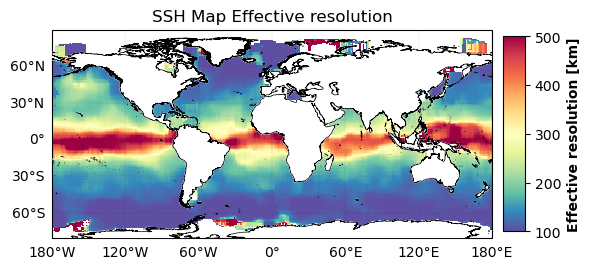

In [14]:
# Plot effective resolution
# Hvplot
# plot_effective_resolution(psd_output_filename)
# Matplotlib
plot_effective_resolution_png(psd_output_filename)

The figure above represents the effective resolution of the SSH gridded product, i.e. the minimun scale resolved in the product. It is defined as the threshold where the power spectral density of the mapping error is two times smaller than the power spectral density of the independent SSH along-track signal. More info can be found in  <a href="https://os.copernicus.org/articles/15/1091/2019/"> Ballarotta et al., 2019</a>.

In [15]:
plot_psd_scores(psd_output_filename)

:Layout
   .DynamicMap.I   :DynamicMap   [lon,lat]
      :Overlay
         .Curve.PSD_alongtrack   :Curve   [wavelenght]   (psd_ref)
         .Curve.NOISE_alongtrack :Curve   [wavelenght]   (noise)
         .Curve.PSD_map          :Curve   [wavelenght]   (psd_study)
         .Curve.PSD_err          :Curve   [wavelenght]   (psd_diff)
   .DynamicMap.II  :DynamicMap   [lon,lat]
      :Overlay
         .Curve.PSD_map_over_PSD_ref :Curve   [wavelenght]   (psd_ratio)
         .Curve.I                    :Curve   [wavelenght]   (coherence)
   .DynamicMap.III :DynamicMap   [lon,lat]
      :Overlay
         .Curve.I  :Curve   [wavelenght]   (psd_score)
         .Curve.II :Curve   [wavelenght]   (coherence)
   .DynamicMap.IV  :DynamicMap   [lon,lat]
      :Overlay
         .Curve.I  :Curve   [wavelenght]   (coherence)
         .Curve.II :Curve   [wavelenght]   (coherence)

The interactive plot above allows you to explore the spectral metrics by latitude / longitude box